Import the neccessary libraries

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score

Data Loading and Initial Inspection

In [58]:
try:
    df = pd.read_csv("Student_Performance.csv")
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: 'Student_Performance' was not found")

Data loaded successfully!


In [59]:
print("First 5 rows of the data")
df.head()

First 5 rows of the data


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [60]:
print("Data Information")
print(df.info())

Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB
None


Feature Engineering

In [61]:
# Define the feature matrix (X) and the target variable (y)
TARGET = "Performance Index"
FEATURES = df.columns.drop(TARGET)

In [62]:
# Separate features by type for preprocessing
numerical_features = df.select_dtypes(include=np.number).columns.drop(TARGET).tolist()
categorical_features = df.select_dtypes(include="object").columns.to_list()

print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")

Numerical Features: ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']
Categorical Features: ['Extracurricular Activities']


Data Visualization before Training

In [63]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

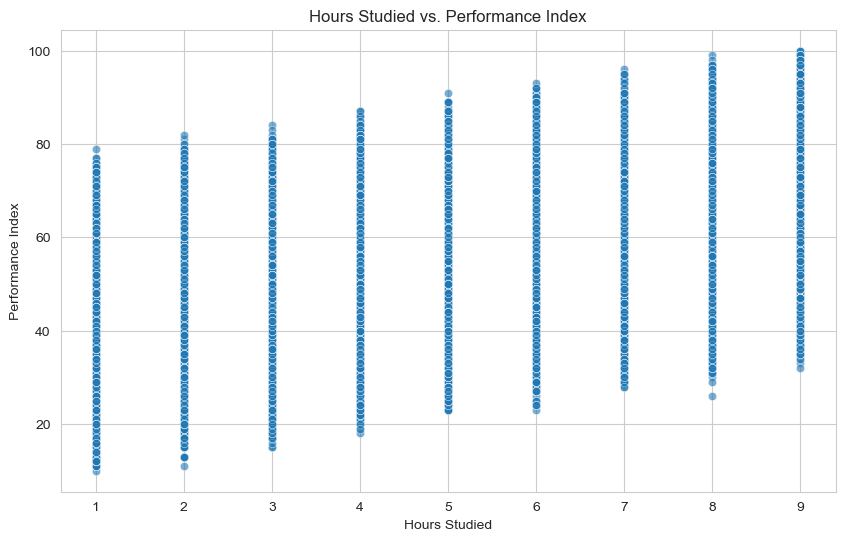

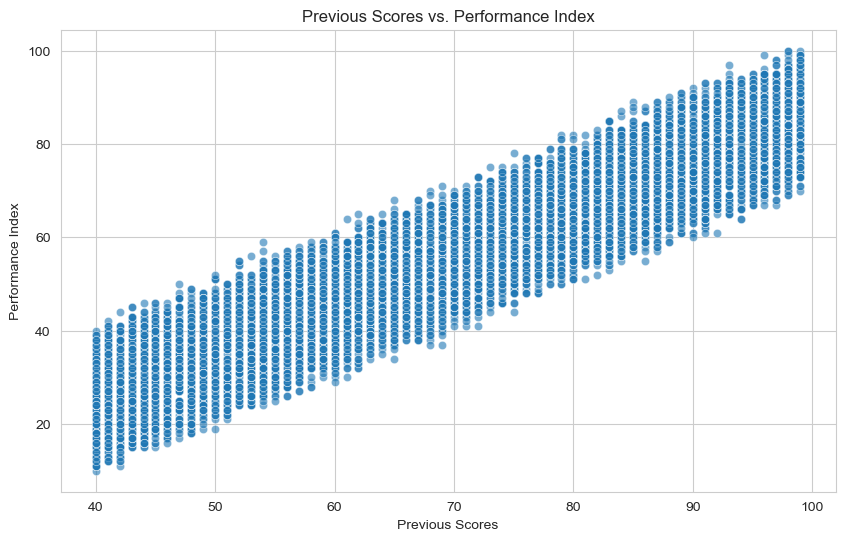

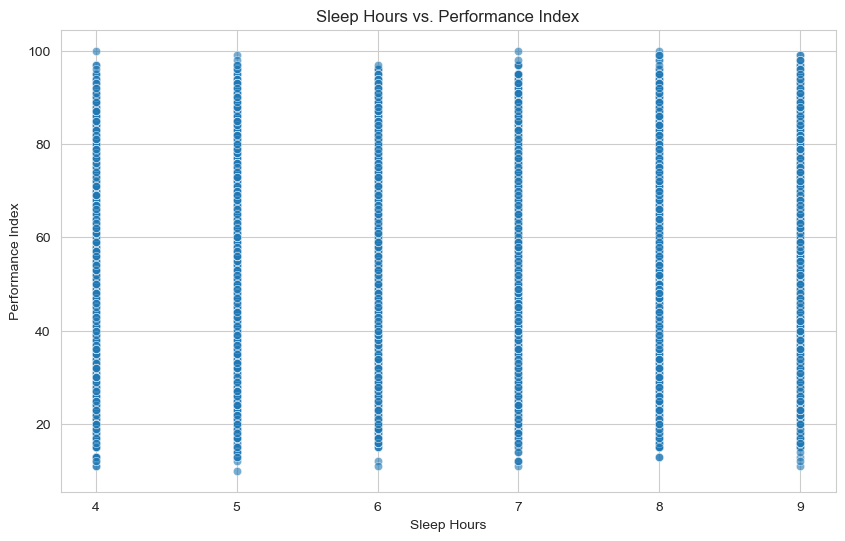

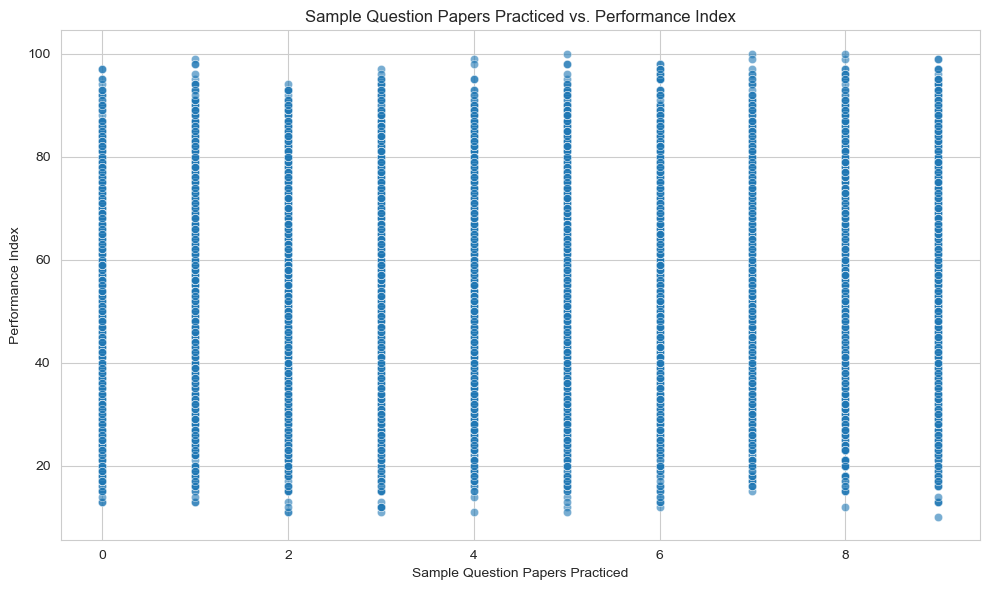

C:\Users\Dell\AppData\Local\Temp\ipykernel_132\2916529367.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[categorical_features[0]],y=df[TARGET],palette="pastel")


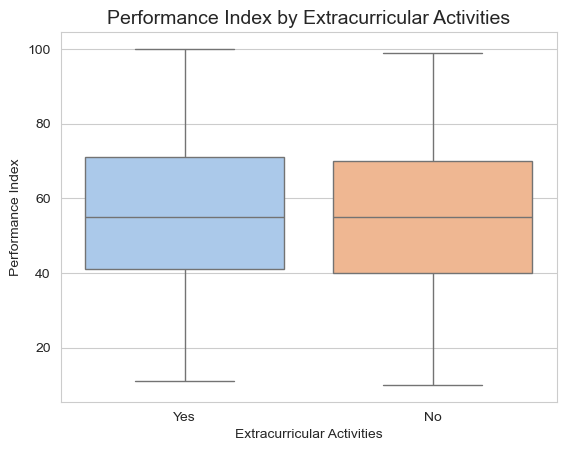

In [64]:
# Create a scatter plots to visualize the relationship between key numerical features and the target variable
# This helps us understand the data distribution and potential correlations
for i, col in enumerate(numerical_features):
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=df[col], y=df[TARGET], alpha=0.6, color='#1f77b4') # Use a nice blue color
    plt.title(f'{col} vs. {TARGET}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel(TARGET, fontsize=10)
plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

# Create a box plot for the categorical feature against the target
plt.Figure(figsize=(6,4))
sns.boxplot(x=df[categorical_features[0]],y=df[TARGET],palette="pastel")
plt.title(f"{TARGET} by {categorical_features[0]}",fontsize=14)
plt.show()

Preprocessing Pipeline Setup

In [65]:
# Create a transformers for different types of features
# 1. Standard Scaler for numerical data (scales features to have zero mean and unit variance)
numerical_transformers = StandardScaler()

In [66]:
# 2. One-Hot Encoder for categorical data (converts categories into numerical columns)
categorical_transformers = OneHotEncoder(handle_unknown="ignore")

In [67]:
# Combine the transformers into a preprocessing using ColumnTransformers
preprocessor = ColumnTransformer(
    transformers=[
        ("num",numerical_transformers,numerical_features),
        ("cat",categorical_transformers,categorical_features)
    ]
)

Feature Engineering

In [68]:
X = df[FEATURES]
y = df[TARGET]

Data Splitting

In [69]:
# Split the data into 80% for training and 20% for testing
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 8000
Testing set size: 2000


Model Comparison and Evaluation

In [70]:
print("----- Model Comparison and Evaluation -----")
models = {
    "Linear Regression" : LinearRegression(),
    "Ridge Regression" : Ridge(random_state=42),
    "Lasso Regression" : Lasso(random_state=42,max_iter=10000),
    "Elastic Net Regression" : ElasticNet(random_state=42,max_iter=10000),
    "Random Forest Regressor" : RandomForestRegressor(random_state=42,n_estimators=100)
}

----- Model Comparison and Evaluation -----


In [71]:
# Dictionary to store the results
results = {}

In [72]:
# Iterate over each model, train it, evaluate it and store results
for name,model in models.items():
    # Create a full pipeline: Preprocessor -> Model
    # This ensures that all steps (scaling, encoding) are applied consistently
    pipeline = Pipeline(steps=[("preprocessor",preprocessor),
                               ("regressor",model)])
    
    print(f"Training {name}....")

    # Train the model pipeline using the training data
    pipeline.fit(X_train,y_train)

    # Make Predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate and store performance metrics
    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)

    results[name] = {
        "R2 Score" : r2,
        "MSE" : mse,
        "Model" : pipeline
    }

    print(f"{name} R2 Score: {r2:.4f}")
    print(f"{name} MSE: {mse:.2f}")


# Convert results dictionary to DataFrame for easy comparison
results_df = pd.DataFrame.from_dict(results,orient="index")
print("----- Model Comparison Results -----")
print(results_df[["R2 Score","MSE"]].sort_values(by="R2 Score",ascending=False))

# Identify the best initial model based on R2 Score
best_model_name = results_df["R2 Score"].idxmax()
best_model = results[best_model_name]["Model"]
print(f"Initial Best Model: {best_model_name}")

Training Linear Regression....
Linear Regression R2 Score: 0.9890
Linear Regression MSE: 4.08
Training Ridge Regression....
Ridge Regression R2 Score: 0.9890
Ridge Regression MSE: 4.08
Training Lasso Regression....
Lasso Regression R2 Score: 0.9797
Lasso Regression MSE: 7.52
Training Elastic Net Regression....
Elastic Net Regression R2 Score: 0.8576
Elastic Net Regression MSE: 52.79
Training Random Forest Regressor....
Random Forest Regressor R2 Score: 0.9861
Random Forest Regressor MSE: 5.16
----- Model Comparison Results -----
                         R2 Score        MSE
Linear Regression        0.988983   4.082628
Ridge Regression         0.988982   4.083212
Random Forest Regressor  0.986064   5.164562
Lasso Regression         0.979716   7.516813
Elastic Net Regression   0.857559  52.786497
Initial Best Model: Linear Regression


Hyperparameter Tuning

In [73]:
print("----- Hyperparameter Tuning on Random Forest Regressor -----")

# We choose the Random Forest Regressor for tuning as it typically benefits greatly for optimization

# Define the regressor instance
rf_regressor = RandomForestRegressor(random_state=42)

----- Hyperparameter Tuning on Random Forest Regressor -----


In [74]:
# Create a pipeline specifically for tuning
tuning_pipeline = Pipeline(steps=[("preprocessor",preprocessor),
                                  ("regressor",rf_regressor)])

In [75]:
# Define the hyprparameter grid to search over
# Parameters must be prefixed with the step name in the pipeline ("regressor__")
param_grid = {
    "regressor__n_estimators" : [50,100,200],
    "regressor__max_depth" : [10,20,None],
    "regressor__min_samples_split" : [2,5]
}
grid_search = GridSearchCV(tuning_pipeline,param_grid,cv=5,scoring="r2",verbose=1,n_jobs=-1)

In [76]:
print("Starting Grid Search...")
# Fit Grid Search to the training data
grid_search.fit(X_train,y_train)

Starting Grid Search...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Hours '
                                                                          'Studied',
                                                                          'Previous '
                                                                          'Scores',
                                                                          'Sleep '
                                                                          'Hours',
                                                                          'Sample '
                                                                          'Question '
                                                                          'Papers '
                                                                          'Practiced']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Extracurricular '
                                                                          'Activities'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [10, 20, None],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [50, 100, 200]},
             scoring='r2', verbose=1)

In [77]:
# Get the best estimator (model with best hyperparameters)
best_rf_model = grid_search.best_estimator_

In [78]:
# Evaluate the tuned model on the test set
y_pred_tuned = best_rf_model.predict(X_test)
r2_tuned = r2_score(y_test,y_pred_tuned)
mse_tuned = mean_squared_error(y_test,y_pred_tuned)

In [79]:
print(f"Best Hyperparameters found: {grid_search.best_params_}")
print(f"Tuned Random Forest R2 Score: {r2_tuned:.4f}")
print(f"Tuned Random Forest MSE: {mse_tuned:.2f}")

Best Hyperparameters found: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Tuned Random Forest R2 Score: 0.9873
Tuned Random Forest MSE: 4.71


Final Visualization After Training

'----- Final Visualization After Training -----


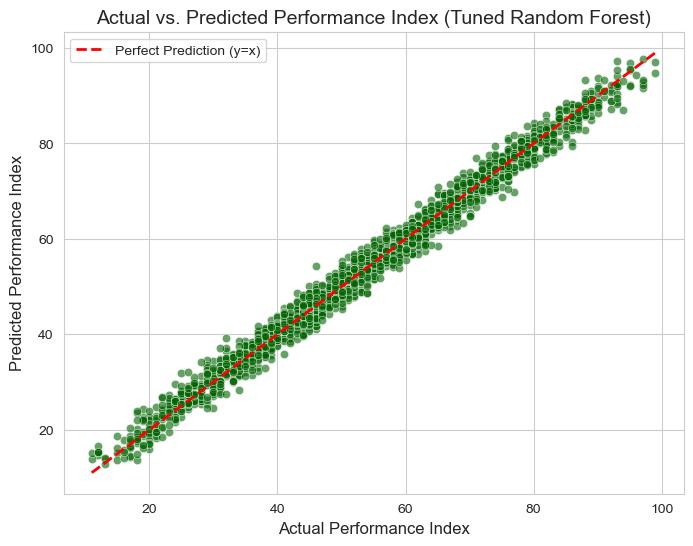

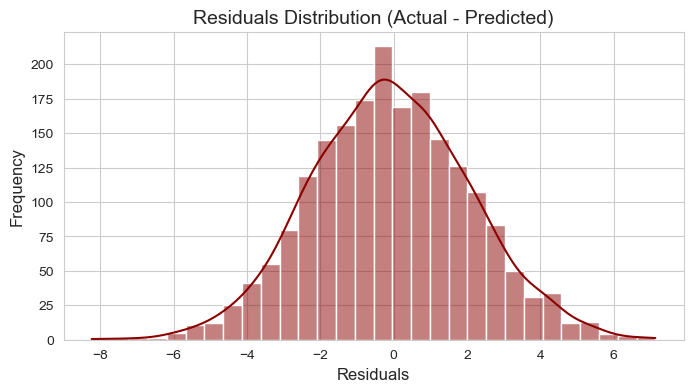

In [80]:
print("'----- Final Visualization After Training -----")

# Compare Actual vs Predicted values for the best performing (Tuned Random Forest) model
plt.figure(figsize=(8, 6))

# Create a scatter plot of Actual values (x-axis) vs. Predicted values (y-axis)
sns.scatterplot(x=y_test, y=y_pred_tuned, alpha=0.6, color='darkgreen') # Dark green for final results

# Add a perfect prediction line (y = x). Points near this line mean better prediction accuracy.
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         '--r', linewidth=2, label='Perfect Prediction (y=x)')

plt.title('Actual vs. Predicted Performance Index (Tuned Random Forest)', fontsize=14)
plt.xlabel('Actual Performance Index', fontsize=12)
plt.ylabel('Predicted Performance Index', fontsize=12)
plt.legend()
plt.show()

# Visualize the residuals (errors = Actual - Predicted)
plt.figure(figsize=(8, 4))
residuals = y_test - y_pred_tuned
sns.histplot(residuals, kde=True, bins=30, color='darkred')
plt.title('Residuals Distribution (Actual - Predicted)', fontsize=14)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()